# Forest Cover Type Prediction
## W207 Final Project: Baseline Report
### _Team RanForest: Anu Yadav, Naga Akkineni, Lina Gurevich, Rishi Majumder_

 ## Table of Contents

   - ### Problem Introduction

   - ### Exploratory Data Analysis
   
       * #### Getting a bird's view of the dataset
       
       * #### Univariate Data Analysis

       
   - ### Data Cleaning and Preprocessing

   - ### Model Selection & Training
   
       * #### Baseline Models
       * #### Feature Standardization
       * #### Model Selection Pipeline
       * #### Error Analysis

   - ### Feature Engineering

   - ### Discussion


## 1. Problem Introduction

Natural resources are key to keep a balance in the ecological life cycle. A larger goal of this project is to map out various types of tree populations in different regions and how deforestation through natural causes like a forest fire or human activities create sustainable environmental impact. <br>

In this study, we will use the data collected from the Roosevelt National Forest, which is located in north central Colorado and covers a total area of 813,799 acres (1,271.56 sq mi). There are six officially designated wilderness areas lying within Roosevelt National Forest that are part of the National Wilderness Preservation System. 

We will focus on the four forest areas characterized by minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

1 - **Rawah Wilderness Area** (119.4 square miles)  
Elevation ranges from 8,400 ft to 13,000 ft.

2 - **Neota Wilderness Area** (15.51 square miles)  
Elevation ranges from 10,000 ft to 11,896 ft.

3 - **Comanche Peak Wilderness Area** (104.4 square miles)  
Elevation ranges from 8,000 ft to 12,702 ft.

4 - **Cache la Poudre Wilderness Area** (14.47 square miles)  
Elevation ranges from 6,200 ft to 8,600 ft.

There are **7** types of forest cover that are common in the park:

<img src="Cover Types.PNG"> 

Our task is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.


## 2. Exploratory Data Analysis

The original dataset contains the following features that can be roughly split into 7 groups:

1. *Landscape*  
**Elevation** - Elevation in meters  
**Aspect** - Aspect in degrees azimuth  
**Slope** - Slope in degrees 


2. *Proximity to water supplies*  
**Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features  
**Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features  


3. *Proximity to human-caused habitat alteration*  
**Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway  


4. *Sun exposure*  
**Hillshade_9am (0 to 255 index)** - Hillshade index at 9am, summer solstice  
**Hillshade_Noon (0 to 255 index)** - Hillshade index at noon, summer solstice  
**Hillshade_3pm (0 to 255 index)** - Hillshade index at 3pm, summer solstice  


5. *Wildfire risk factor*  
**Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points  


6. *Location within the park*  
**Wilderness_Area (4 binary columns, 0 = absence or 1 = presence)** - Wilderness area designation  


7. *Type of soil*  
**Soil_Type (40 binary columns, 0 = absence or 1 = presence)** - Soil Type designation

Prior to conducting a thorough quantitative analysis, we can reason that any of the features listed above may affect the type of the predominant forest cover in a particular area. Therefore, we will retain all the features at this stage of our investigation.

In [1]:
# Import necessary modules and libraries

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

import sklearn.metrics
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the training dataset into a pandas dataframe
raw_data = pd.read_csv("train.csv")
print("Original dataset shape: ", raw_data.shape)

Original dataset shape:  (15120, 56)


**Observations:**  

- The original dataset consists of 15,120 observations, each with 55 features and 1 target variable.

## 2.1 Getting a bird's view of the dataset

- How many observations and features are there?

- What are the variable types (e.g., continuous numeric, categorical, binary, etc.)? 

- What are the descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution?

- Do we have any missing values? If yes, how do we deal with them (e.g., removing features/observations based on certain criteria, imputing missing values)?

- Are there any duplicated rows? If yes, remove them.

- How many distinct values does each feature have? It will help us identify and drop the features that offered no variability (i.e., having the same value for all observations).

In [3]:
# Check if there're duplicated rows
print ("Number of duplicated rows: ",raw_data.duplicated().sum())
#raw_data.drop_duplicates()

Number of duplicated rows:  0


In [4]:
# Check if there're any missing values
print("Number of missing values:", raw_data.isnull().sum().sum())
#raw_data.dropna()

Number of missing values: 0


In [5]:
# Check columns' data types
print(raw_data.dtypes)

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

**Observations:**  

- All the variables in the dataset are encoded as integers, including categorical features (i.e., `Hillshade_*`)

In [6]:
# Display general statistics
pd.set_option('display.max_columns', None)
raw_data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [7]:
# Check how many distinct values does each feature have
print("\nNumber of distinct values:\n")
for column in list(raw_data.columns):
    print ("{0:25} {1}".format(column, raw_data[column].nunique()))


Number of distinct values:

Id                        15120
Elevation                 1665
Aspect                    361
Slope                     52
Horizontal_Distance_To_Hydrology 400
Vertical_Distance_To_Hydrology 423
Horizontal_Distance_To_Roadways 3250
Hillshade_9am             176
Hillshade_Noon            141
Hillshade_3pm             247
Horizontal_Distance_To_Fire_Points 2710
Wilderness_Area1          2
Wilderness_Area2          2
Wilderness_Area3          2
Wilderness_Area4          2
Soil_Type1                2
Soil_Type2                2
Soil_Type3                2
Soil_Type4                2
Soil_Type5                2
Soil_Type6                2
Soil_Type7                1
Soil_Type8                2
Soil_Type9                2
Soil_Type10               2
Soil_Type11               2
Soil_Type12               2
Soil_Type13               2
Soil_Type14               2
Soil_Type15               1
Soil_Type16               2
Soil_Type17               2
Soil_Type18           

**Observations:**  

- The `Id` column represents a unique observation identifier, and as such has the value-spread identical to the number of samples in the dataset. Since it's an arbitrary number containing no meaningful information relevant to the cover type classification, we should exclude it from our analysis.  


- The columns from `Elevation` to `Horizontal_Distance_To_Fire_Points` display reasonable variety in their values.  


- `Wilderness_Area*` and `Soil_Type*` are binary variables generated from the respective categorical features via one-hot encoding. Hence, we expect to see 2 unique values for each variable. We observe two exceptions to the rule: `Soil_Type7` and `Soil_Type15` have only one unique value, which means it's identical for every sample in the dataset. Therefore, these features are redundant and should be removed from the analysis.

## 2.2 Univariate Data Analysis

In this section, we'll explore properties of individual features. 

###  Cover_Type (target variable)

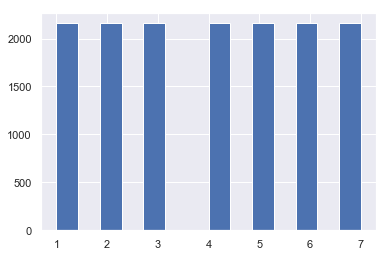

In [8]:
# Generate the feature histogram to check if the label distribution is balanced within the dataset
raw_data.Cover_Type.hist(bins=14)

**Observations:**  

- The Cover Type categories are uniformly distributed in the dataset, thus ensuring that our training data is well-balanced.  


### Elevation

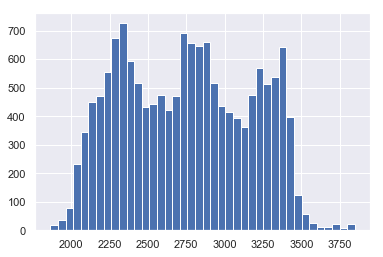

In [9]:
# Generate histogram of elevations
raw_data.Elevation.hist(bins=40)

**Observations:**  

- Elevation is a continuous variable with distribution exhibiting at least three distinct clusters.


### Aspect  

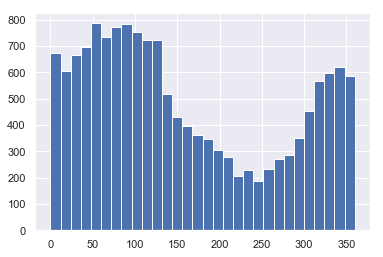

In [10]:
raw_data.Aspect.hist(bins=30)

In [11]:
# Check how many records do we have with Aspect = 360
print("\nSamples with 360 degrees Aspect:\n")
raw_data[(raw_data.Aspect == 360)]


Samples with 360 degrees Aspect:



,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
2343,2344,2062,360,30,300,213,272,162,171,135,845,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
12204,12205,2046,360,29,124,97,150,165,174,136,127,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


<img align="left" src="azimuth.gif">

**Observations:**  

-  Aspect is measured in degrees azimuth and as such its range is between 0 and 360.  


- Two samples have their Aspect values set to 360. Since it's identical to Aspect = 0, we'll need to replace these values with 0.  


- Alternatively, we might want to bin the entire range of Aspect degrees into 4 categorical values:  

1 = North (315 to 45)  
2 = East  (45 to 135)  
3 = South  (135 to 225)   
4 = West  (225 to 315)

### Slope

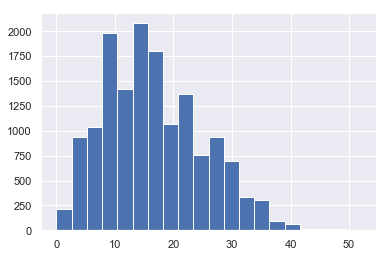

In [12]:
raw_data.Slope.hist(bins=20)

### Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology

Text(0.5,1,'Histogram of Vertical Distance to Hydrology')

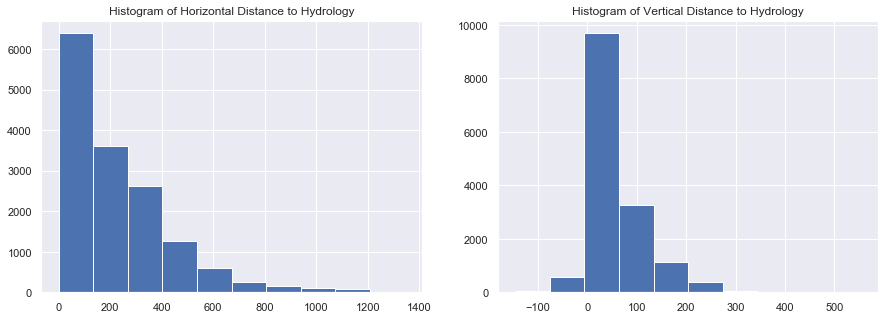

In [13]:
plt.figure(figsize=(15,5))

# Horizontal Distance
plt.subplot(1, 2, 1)
plt.hist(raw_data.Horizontal_Distance_To_Hydrology)
plt.title("Histogram of Horizontal Distance to Hydrology")

# Vertical Distance
plt.subplot(1, 2, 2)
plt.hist(raw_data.Vertical_Distance_To_Hydrology)
plt.title("Histogram of Vertical Distance to Hydrology")

**Observations:**  

- Horizontal distances to hydrology are non-negative and have a strong positive skew. This is what we would expect to see since trees tend to populate areas that are close to water supplies.  


- Vertical distances, on the other hand, can be encoded as negative values to indicate whether the water source is below or above the particular forest patch.


### Horizontal_Distance_To_Roadways

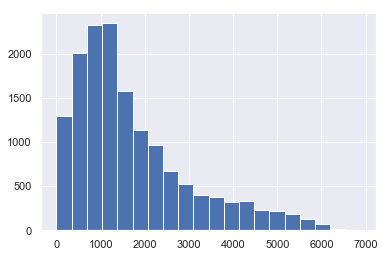

In [14]:
raw_data.Horizontal_Distance_To_Roadways.hist(bins=20)

### Hillshade (9 am, noon, 3 pm)

Text(0.5,1,'Histogram of 3 pm Hillshade index')

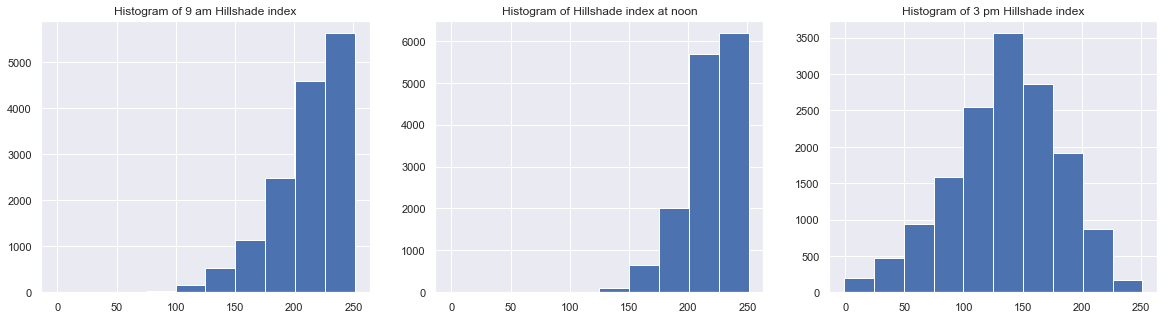

In [15]:
plt.figure(figsize=(20,5))

# Hillshade, 9 am
plt.subplot(1, 3, 1)
plt.hist(raw_data.Hillshade_9am, range=(-1,251))
plt.title("Histogram of 9 am Hillshade index")

# Hillshade, noon
plt.subplot(1, 3, 2)
plt.hist(raw_data.Hillshade_Noon, range=(-1,251))
plt.title("Histogram of Hillshade index at noon")

# Hillshade, 3 pm
plt.subplot(1, 3, 3)
plt.hist(raw_data.Hillshade_3pm, range=(-1,251))
plt.title("Histogram of 3 pm Hillshade index")

**Observations:**  

- The shade index distributions exhibit strong negative skews during the morning and noon hours, when the forest areas are the most exposed to the sun.  


- The shade distribution approaches normal in the early afternoon.


### Horizontal_Distance_To_Fire_Points

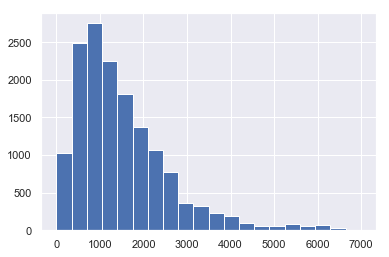

In [16]:
raw_data.Horizontal_Distance_To_Fire_Points.hist(bins=20)

*Note:*  

To explore the distributions of `Wilderness_Area` and `Soil_Type` features, we need to collapse their one-hot encoding back to the original categorical values.

### Wilderness Area  

Number of samples for each Wilderness Area:
3    6349
4    4675
1    3597
2     499
dtype: int64


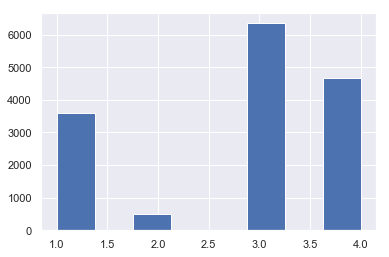

In [17]:
# Reverse one-hot encoding for wilderness areas
Wilderness_Area = raw_data.loc[:, 'Wilderness_Area1':'Wilderness_Area4']
Wilderness_Area = Wilderness_Area.idxmax(axis=1).replace(regex=r'Wilderness_Area*', value='').astype(int)

# Generate the histogram
Wilderness_Area.hist(bins=8)

print("Number of samples for each Wilderness Area:")
print(Wilderness_Area.value_counts())

**Observations:**  

- Wilderness Area 2 has much smaller number of observations in the dataset compared to other forest areas. One possible explanation is that this is the area with the highest minimum elevation (refer to the details in Problem Introduction), thus making it more challenging for data collection.

In [18]:
# Check if Area 2 indeed has the highest minimum elevation

print("Minimum elevation for different wilderness areas, meters:\n")
      
print("Area 1:\t%g" %raw_data.Elevation[raw_data.Wilderness_Area1 == 1].min())
print("Area 2:\t%g" %raw_data.Elevation[raw_data.Wilderness_Area2 == 1].min())
print("Area 3:\t%g" %raw_data.Elevation[raw_data.Wilderness_Area3 == 1].min())
print("Area 4:\t%g" %raw_data.Elevation[raw_data.Wilderness_Area4 == 1].min())

Minimum elevation for different wilderness areas, meters:

Area 1:	2482
Area 2:	2978
Area 3:	2301
Area 4:	1863


### Soil Type

Number of samples for each Soil Type:
10    2142
29    1291
3      962
4      843
23     757
38     728
30     725
32     690
39     657
6      650
2      623
33     616
17     612
13     476
40     459
11     406
1      355
22     345
31     332
24     257
12     227
14     169
5      165
20     139
16     114
35     102
18      60
26      54
19      46
37      34
34      22
21      16
27      15
9       10
36      10
28       9
25       1
8        1
dtype: int64


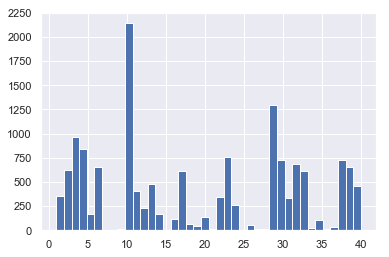

In [19]:
# Reverse one-hot encoding for soil type variable
Soil_Type = raw_data.loc[:, 'Soil_Type1':'Soil_Type40']
Soil_Type = Soil_Type.idxmax(axis=1).replace(regex=r'Soil_Type*', value='').astype(int)

# Plot the histogram
Soil_Type.hist(bins=40)

print("Number of samples for each Soil Type:")
print(Soil_Type.value_counts())

**Observations:**  

- We have already established earlier that Soil Types 7 and 15 are missing from the dataset, justifying removal of these features.  


- From the value counts for other types of soil we notice that Types 25 and 8 have just one sample each. As a result, we might consider removing them as well. In general, we could try experimenting with different cut-off threshold values and remove features with counts below the threshold.

## 3. Data Cleaning & Preprocessing

In this section, we will perform basic data cleaning guided by what we have learned from the exploratory analysis.  

We will then create a baseline dataset and split it into training, validation, and test sets.  

In [20]:
# Extract all the columns except Id and Cover_type:
baseline_features = raw_data.loc[:, 'Elevation':'Soil_Type40']

# Extract target variable
y = raw_data.Cover_Type

# Remove redundant columns
baseline_features = baseline_features.drop(columns=['Soil_Type7', 'Soil_Type15', 'Soil_Type25', 'Soil_Type8'])

# Replace 360 degrees aspect with 0 degrees
baseline_features.Aspect = baseline_features.Aspect.replace(360, 0)

# Verify dataset shape and content
print(baseline_features.shape)

baseline_features.head()

(15120, 50)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Randomly split the dataset into training and test sets
bl_train, bl_test_tmp, y_train, y_test_tmp = train_test_split(baseline_features, y, test_size=0.2, random_state=42)

# Split the test set further into test and validation subsets
bl_test, bl_val, y_test, y_val = train_test_split(bl_test_tmp, y_test_tmp, test_size=0.5, random_state=0)

print("Baseline Training Set:", bl_train.shape)
print("Training Set Labels:", y_train.shape)
print("Baseline Validation Set:", bl_val.shape)
print("Validation Labels:", y_val.shape)
print("Baseline Test Set:", bl_test.shape)
print("Test Labels:", y_test.shape)

Baseline Training Set: (12096, 50)
Training Set Labels: (12096,)
Baseline Validation Set: (1512, 50)
Validation Labels: (1512,)
Baseline Test Set: (1512, 50)
Test Labels: (1512,)


## 4. Model Selection & Training

Forest cover prediction is a multi-class classification problem that can be solved by a number of supervised learning algorithms, each of them having their strengths and limitations.  

Since we do not know in advance which model will be the best fit for our data, we decided to perform a search over a range of learning algorithms and their respective hyperparameters.  

We will start with the dataset generated in the previous section that contains almost all the original features with no transformation applied to them. This will allow us to establish a baseline metric for performance evaluation.  

We will then try to improve the results by selecting a subset of important features and possibly engineering some new ones.

We will focus our search on 4 learning algorithms with a proven performance record of solving various classification problems:

-  Naive Bayes
-  Logistic Regression
-  KNN
-  Ensemble methods (e.g., Random Forest)


### 4.1 Baseline Models

In [22]:
print('Gaussian Naive Bayes ------------------------')
model = GaussianNB()
model.fit(bl_train, y_train)
result1 = model.score(bl_val, y_val)
print ('\n  Accuracy on the validation data set (10% of the train data) is {0:.3f}% '.\
                    format(result1*100))

print('\n\n KNN ------------------------')
model2 = KNeighborsClassifier()
model2.fit(bl_train, y_train)
result2 = model2.score(bl_val, y_val)
print ('\n  Accuracy on the validation data set (10% of the train data) is {0:.3f}% '.\
                    format(result2*100))

print('\n\n Random Forest -------------------------')
model3 = RandomForestClassifier()
model3.fit(bl_train, y_train)
result3 = model3.score(bl_val, y_val)
print ('\n  Accuracy on the validation data set (10% of the train data) is {0:.3f}% '.\
                    format(result3*100))

print('\n\n Logistic Regression -------------------------')
model4 = LogisticRegression()
model4.fit(bl_train, y_train)
result4 = model4.score(bl_val, y_val)
print ('\n  Accuracy on the validation data set (10% of the train data) is {0:.3f}% '.\
                    format(result4*100))



Gaussian Naive Bayes ------------------------

  Accuracy on the validation data set (10% of the train data) is 60.450% 


 KNN ------------------------

  Accuracy on the validation data set (10% of the train data) is 81.085% 


 Random Forest -------------------------

  Accuracy on the validation data set (10% of the train data) is 84.524% 


 Logistic Regression -------------------------

  Accuracy on the validation data set (10% of the train data) is 66.336% 


### 4.2 Feature Standardization

Many machine learning algorithms require feature set to be normalized prior to training.

To achieve this, we use standardization to transform the data such that it has a mean, $x̄$, of 0 and a standard deviation, σ, of 1.  

Specifically, each element in the feature is transformed so that: $x^{′}_{i}=\frac{x_{i}−\bar{x}}{σ}$

In [23]:
# Create scaler
scaler = StandardScaler()

# Standardize the training set
bl_train_std = scaler.fit_transform(bl_train)

# Transform validation & test sets
bl_val_std = scaler.transform(bl_val)
bl_test_std = scaler.transform(bl_test)

### 4.3 Model Selection Pipeline

In this step, we define a search space that includes the four classifiers described earlier.  

For each learning algorithm, we'll specify the range of hyperparameter values which we'd like to optimize.  

Finally, we perform the grid search over all the defined classifiers and their respective hyperparameters to select the best performing model.

### 4.4 Error Analysis

- Using the best model from the previous section, generate predictions on the validation set.  


- Generate Classification Report.


- Visualize the results by outputting the Confusion Matrix.  


- Generate ROC plot and calculate the Area Under the Curve.

## 5. Feature Engineering

Guided by our data and error analysis conducted earlier, we will try to improve the performance of our basline model by carefully engineering the features.  

1. Reducing feature space dimensionality to address the overfitting:
    - Identifying and removing features with low variance
    - Identifying and removing highly-correlated features
    - Identifying and removing irrelevant features (e.g., features that have no correlation with the target variable)
    - Using PCA to automatically select the most important features
    
    
2. Generating new features to increase model's ability to capture the meaningful variability within the data:
    - Creating interaction terms
    - Adding polynomial features
    
    
3. Transforming existing features:
   - Discretizing (binning) continuous variables (e.g., Aspect)

In [24]:
# Remove binary features with low variance
binary_features = raw_data.loc[:, 'Wilderness_Area1':'Soil_Type40']
print(binary_features.shape)
thresholder = VarianceThreshold(threshold=(.995 * (1 - .995)))
binary_features = thresholder.fit_transform(binary_features)
print(binary_features.shape)

(15120, 44)
(15120, 30)


In [25]:
# Remove highly correlated features
uncorrelated_features = raw_data.loc[:, 'Elevation':'Soil_Type40']
corr_matrix = uncorrelated_features.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print(to_drop)

[]


## 6. Discusssion

TBD